### Extract NDVI at pasture scale for calculating integrated APAR

#### Package inputs

In [1]:
import xarray as xr
import rioxarray as riox
import rasterio as rio
import numpy as np
import os
import re
import pandas as pd
import geopandas as gpd
from datetime import datetime, timedelta
from tqdm.notebook import tqdm
import time
import json
from shapely import wkt
from itertools import chain
from hlsstack.hls_funcs import fetch
from hlsstack.hls_funcs.masks import mask_hls, shp2mask, bolton_mask_xr, atsa_mask
from hlsstack.hls_funcs.indices import ndvi_func
from hlsstack.hls_funcs.smooth import despike_ts, double_savgol
import gc
from glob import glob
import matplotlib.pyplot as plt

#### Specify parameters

##### Specify input/output paths

In [18]:
# path to scan sites location data
aoi_shp = './data/boundaries/CPER_Scan_sites_ndvi_polys.shp'
# directory for landsat-modis fusion (LMF) data in netcdf form
#lmfDIR = '/90daydata/cper_neon_aop/cper_lmf_netcdf/'
lmfDIR = '/mnt/e/LMF_STARFM_netcdf/'
#lmfDIR = '/mnt/t/3-GIS/CPER/Layers/CPER_Landsat-Modis-Fusion_V3'

# specify years to run
yr_start = 2000
yr_end = 2023

# output paths
outPATH_ndvi = './data/extractions/cper_scan_ndvi_' + str(yr_start) + '_' + str(yr_end) + '.csv'

##### Specifiy other parameters

In [14]:
# dask cluster location
cluster_loc = 'local'

# whether use Landsat-MODIS (LMF) fusion data when available
use_lmf = True
# last year for LMF data
lmf_yr_max = 2015
# whether to try applying the ATSA cloud/shadow mask
try_atsa = True
# whether to apply the Bolton et al. masking approach
mask_bolton = False

##### Set up dask cluster

In [4]:
if cluster_loc == 'local':
    print('   setting up Local cluster...')
    from dask.distributed import LocalCluster, Client
    import dask
    aws=False
    # don't process on local resources - can't handle ATSA mask
    process_hls = False
    fetch.setup_env(aws=aws)
    cluster = LocalCluster(n_workers=8, threads_per_worker=2)
    num_jobs=8
    client = Client(cluster)
    display(client)
elif cluster_loc == 'hpc':
    from dask.distributed import LocalCluster, Client
    import dask_jobqueue as jq
    import dask
    from jupyter_server import serverapp
    # get the server address for porting
    try:
        jupServer = [x for x in serverapp.list_running_servers()][0]
    except IndexError:
        # manually copy/paste the server address
        jupServer = {'base_url': '/node/ceres19-compute-98-eth.scinet.local/17710/'}
    print('   setting up cluster on HPC...')
    import psutil
    interface_prefs = [
        'ibp175s0',
        'ibp59s0',
        'enp24s0f0',
        'ens7f0']
    interface = [x for x in interface_prefs if x in list(psutil.net_if_addrs().keys())][0]
    if len(interface) == 0:
        print('ERROR: Preferred interfaces not found on node!')
    else:
        print(interface)
    aws=False
    process_hls = True
    fetch.setup_env(aws=aws)
    dask.config.set({'distributed.dashboard.link': jupServer['base_url'] + 'proxy/{port}/status'})
    partition='brief-low',#'short','debug', 'mem', 'mem-low',
    num_processes = 4
    num_threads_per_processes = 2
    mem = 2.5*num_processes*num_threads_per_processes
    n_cores_per_job = num_processes*num_threads_per_processes
    clust = jq.SLURMCluster(queue=partition,
                            processes=num_processes,
                            cores=n_cores_per_job,
                            memory=str(mem)+'GB',
                            interface=interface,
                            local_directory='$TMPDIR',
                            death_timeout=30,
                            walltime='02:00:00',
                            job_extra_directives=["--nodes=1", "--output=/dev/null","--error=/dev/null"])
    client=Client(clust)
    #Scale Cluster 
    num_jobs=16
    clust.scale(jobs=num_jobs)
    try:
        client.wait_for_workers(n_workers=num_jobs*num_processes, timeout=60)
    except dask.distributed.TimeoutError as e:
        print(str(num_jobs*num_processes) + ' workers not available. Continuing with available workers.')
        #print(e)
        pass
    display(client)

   setting up Local cluster...


2024-05-06 13:50:07,170 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-shphhodp', purging
2024-05-06 13:50:07,180 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-1g2afr9d', purging
2024-05-06 13:50:07,182 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-wv6id6tw', purging
2024-05-06 13:50:07,187 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-1hsy86u8', purging
2024-05-06 13:50:07,202 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-_ix8ljl0', purging
2024-05-06 13:50:07,211 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-_p14mllg', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 11.85 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40479,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 11.85 GiB
Comm: tcp://127.0.0.1:39217,Total threads: 2
Dashboard: http://127.0.0.1:44013/status,Memory: 1.48 GiB
Nanny: tcp://127.0.0.1:41321,


2024-05-06 13:54:47,516 - distributed.nanny - WARNING - Restarting worker
2024-05-06 13:54:47,519 - distributed.nanny - WARNING - Restarting worker
2024-05-06 13:54:47,528 - distributed.nanny - WARNING - Restarting worker
2024-05-06 13:54:47,537 - distributed.nanny - WARNING - Restarting worker
2024-05-06 13:54:47,547 - distributed.nanny - WARNING - Restarting worker
2024-05-06 13:54:47,556 - distributed.nanny - WARNING - Restarting worker
2024-05-06 13:54:47,586 - distributed.nanny - WARNING - Restarting worker
2024-05-06 13:54:47,591 - distributed.nanny - WARNING - Restarting worker
2024-05-06 13:55:36,394 - distributed.nanny - WARNING - Restarting worker
2024-05-06 13:55:36,412 - distributed.nanny - WARNING - Restarting worker
2024-05-06 13:55:36,422 - distributed.nanny - WARNING - Restarting worker
2024-05-06 13:55:36,437 - distributed.nanny - WARNING - Restarting worker
2024-05-06 13:55:36,442 - distributed.nanny - WARNING - Restarting worker
2024-05-06 13:55:36,455 - distributed.

#### Create helper functions

In [5]:
from scipy.signal import savgol_filter

def adapt_smooth_ndvi(ts, dates, despike=True, dat_thresh=None, limit=91):
    ct_valid = sum(~np.isnan(ts[(dates.dt.month >= 5) & (dates.dt.month <= 10)]))
    ct_total = len(ts[(dates.dt.month >= 5) & (dates.dt.month <= 10)])
    avg_gap = ct_total/ct_valid
    if ct_valid > 0:
        if avg_gap > 15:
            despike = False
        if despike:
            if dat_thresh is None:
                _dat_thresh = np.ptp(ts.values) * 0.10
            else:
                _dat_thresh = dat_thresh
            ts_ds = despike_ts(ts.values, dat_thresh=_dat_thresh, days_thresh=45)
        else:
            ts_ds = ts.values
        if avg_gap > 10:
            ts_smooth = double_savgol(ts_ds, double=True, window1_max=7, window2=21, limit=limit)
        elif avg_gap > 7:
             ts_smooth = double_savgol(ts_ds, double=True, window1_max=5, window2=25, limit=limit)
        elif avg_gap > 5:
             ts_smooth = double_savgol(ts_ds, double=True, window1_max=5, window2=31, limit=limit)
        else:
            ts_smooth = double_savgol(ts_ds, double=False, window2=35, limit=limit)
    else:
        ts_smooth = ts
    return pd.Series(ts_smooth, ts.index.get_level_values(-1))

def full_smooth_ndvi(ts, dates):
    ndvi_min = ts[(dates.dt.month < 3) | (dates.dt.month > 10)].quantile(0.05)
    ts_ds = pd.Series(
        despike_ts(ts.values, dat_thresh=0.025, days_thresh=61)).interpolate(limit=None)
    ts_smooth = pd.Series(savgol_filter(ts_ds, 91, 3), index=ts.index)
    return ts_smooth

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)

# explore creating SOS
def calc_sos(ndvi_ts):
    if len(ndvi_ts) > 335:
        ndvi_thresh1 = np.nanpercentile(ndvi_ts[91:201], 40.0)
        date_thresh1 = next(x for x in np.where(ndvi_ts > ndvi_thresh1)[0] if x > 30)
        dndvi_ts = np.ones_like(ndvi_ts) * np.nan
        dndvi_ts[25:] = running_mean(np.diff(ndvi_ts), 25)
        dndvi_thresh2 = np.nanpercentile(dndvi_ts[:date_thresh1], 35.0)
        try:
            sos = np.where(dndvi_ts[:date_thresh1] < dndvi_thresh2)[0][-1]
            return sos
        except IndexError:
            return np.nan
    else:
        return np.nan

def weighted_ndvi(ndvi_smooth1, ndvi_smooth2, dates, days_max=90):
    pks = find_peaks(ndvi_smooth1, height=(0.25, None), prominence=(0.025, None))
    days_from_peak = dates.apply(lambda x: min(abs(x - dates.iloc[pks[0]])))
    weights1 = days_from_peak.dt.days.apply(lambda x: 0 if x > days_max else 1 - x/days_max)
    weights2 = 1.0 - weights1
    ndvi_wtd = np.average(np.array([ndvi_smooth1, ndvi_smooth2]), axis=0, weights=np.array([weights1, weights2]))
    return pd.Series(ndvi_wtd, index=ndvi_smooth1.index)

#### Load and prepare datasets

##### Load data

In [6]:
gdf_aoi = gpd.read_file(aoi_shp)

In [12]:
#num_jobs=8

<Axes: >

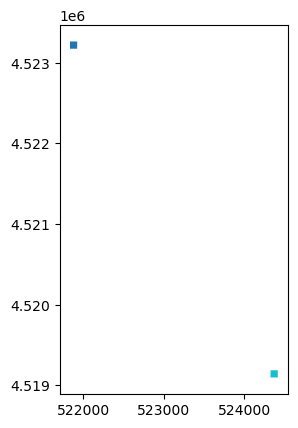

In [8]:
gdf_aoi.plot(column='name')

#### Extract daily NDVI

##### Prep output file

In [9]:
# load any existing output data
if os.path.exists(outPATH_ndvi):
    df_out_ndvi = pd.read_csv(outPATH_ndvi, parse_dates=[0])
else:
    df_out_ndvi = None

In [10]:
#client.restart()

##### Loop through years and extract and smooth NDVI from LMF or HLS

In [20]:
for yr in range(yr_start, yr_end+1):
    print(yr)
    # skip if year already in output data
    if df_out_ndvi is not None and yr in pd.to_datetime(df_out_ndvi['Date']).dt.year.unique():
        print('Skipping year - already in output dataset.')
        continue
    # skip HLS if on local cluster and can't handle ATSA mask
    elif not process_hls and (yr > lmf_yr_max):
        print('Skipping year - not set to process HLS')
        continue
    else:
        # set the bounding box for fetching data
        bbox = np.array(gdf_aoi.total_bounds) # the entire subset dataset
        if use_lmf and yr <= lmf_yr_max:
            # get the LMF netcdf dataset for the year
            lmfPATH_yr = glob(os.path.join(lmfDIR, 'CPER_' + str(yr) + '*.nc'))
            if len(lmfPATH_yr) == 1:
                print('Extracting from LMF')
                # load the dataset to memory after masking
                lmf_ds = riox.open_rasterio(lmfPATH_yr[0], 
                              nodata=-9999, mask=True).sel(x=slice(bbox[0], bbox[2]),
                                                           y=slice(bbox[3], bbox[1]))
                
                lmf_ds = lmf_ds.rename({'DOY': 'Date'})
                lmf_ds['Date'] = [datetime(yr, 1, 1) + timedelta(days=int(x)-1) for x in lmf_ds['Date'].values]
                # chunk the dataset for efficient processing and save as a new dataset
                sat_ds = lmf_ds.chunk({'Date': -1, 'y': 50, 'x': 50})
            else:
                print('Warning! ERROR: path not found or multiple paths match wildcard.')
                print('Searching for year: ', str(yr), '. Found: ')
                print(lmfPATH_yr)
                continue
        else:
            print('Extracting from HLS')
            # get the date range for the fetch as a dictionary
            start_date = str(yr - 1) + "-11-01"
            end_date = str(yr + 1) + "-03-01"
            data_dict = {'date_range': [str(start_date), 
                                        str(end_date)]}

            idx_load_try = 0
            max_load_try = 5
            while idx_load_try < max_load_try:
                try: 
                    # make sure there are at least some workers before fetching data
                    client.wait_for_workers(n_workers=int(num_jobs*0.5), timeout=500)
                    # fetch the data for the entire year's dataset
                    hls_ds = fetch.get_hls(hls_data=data_dict,
                                           bbox=bbox, 
                                           stack_chunks=(1, -1, 400, 400),
                                           proj_epsg=32613,
                                           debug=False,
                                           lim=1000).load()
                    idx_load_try = max_load_try
                except rio.errors.RasterioIOError:
                    if idx_load_try == max_load_try:
                        print('Fetching HLS failed for the max number of tries. Ending.')
                        break
                    else:
                        print('Warning: error loading data. Retrying ' + str(idx_load_try+1) + ' of ' + str(max_load_try))
                        client.restart(wait_for_workers=False)
                        client.wait_for_workers(n_workers=int(num_jobs*0.5), timeout=500)
                        idx_load_try += 1   
                except RuntimeError:
                    if idx_load_try == max_load_try:
                        print('Fetching HLS failed for the max number of tries. Ending.')
                        break
                    else:
                        print('Warning: error loading data. Retrying ' + str(idx_load_try+1) + ' of ' + str(max_load_try))
                        client.restart(wait_for_workers=False)
                        client.wait_for_workers(n_workers=int(num_jobs*0.5), timeout=500)
                        idx_load_try += 1  

            # create a tile ID coordinate
            hls_ds = hls_ds.assign_coords(tile_id = ('time', [x.split('.')[2] for x in hls_ds['id'].values]))

            # pick best image for any dates with duplicate images for the same tile
            if len(hls_ds['time'].groupby('tile_id').apply(lambda x: x.drop_duplicates('time', False))) < len(hls_ds['time']):
                hls_mask = mask_hls(hls_ds['FMASK'], mask_types=['all'])
                hls_ds['maskcov_pct'] = ((hls_mask != 0).sum(['y', 'x']) / hls_ds['FMASK'].isel(time=0).size * 100)#
                hls_ds = hls_ds.groupby('tile_id').apply(lambda x: x.sortby('maskcov_pct').drop_duplicates('time', keep='first')).sortby('time').compute()

            # compute ATSA mask if possible
            if try_atsa:
                print('masking out clouds and shadows detected by ATSA')
                if len(np.unique(hls_ds.tile_id)) > 1:
                    hls_atsa = hls_ds.groupby('tile_id').apply(lambda x: atsa_mask(x.where(
                        x['BLUE'].notnull(), drop=True))).compute()
                    hls_atsa = hls_atsa.transpose('time', 'y', 'x')
                else:
                    hls_ds = hls_ds.reset_coords(drop=True)
                    try:
                        hls_atsa = atsa_mask(hls_ds).compute()
                        mask_atsa = True
                    except ValueError or IndexError:
                        print('WARNING: Could not compute ATSA cloud/shadow mask')
                        mask_atsa = False
                        pass
            else:
                mask_atsa = False

            if mask_bolton:
                # compute the bolton mask
                hls_bolton_mask = bolton_mask_xr(hls_ds).compute()
                hls_ds = xr.merge([hls_ds, hls_atsa], join='inner')
                hls_ds.where(hls_ds['BOLTON'] == 0, drop=True)

            # compute native HLS mask
            hls_mask = mask_hls(hls_ds['FMASK'], mask_types=['cirrus',
                                                            'cloud',
                                                            'cloud_adj',
                                                            'shadow', 
                                                            'snow',
                                                            'water',
                                                            'high_aerosol'])
            # mask using native HLS mask
            hls_ds = hls_ds.where(hls_mask == 0)
            # mask using ATSA mask, if available
            if mask_atsa:
                # merge ATSA mask with HLS data
                hls_ds = xr.merge([hls_ds, hls_atsa], join='inner')
                hls_ds = hls_ds.where(hls_ds['ATSA'] == 1)

            # in case multiple tile_id's still exist, take the mean by pixel
            if 'tile_id' in hls_ds.coords and len(np.unique(hls_ds.tile_id.values)) > 1:
                hls_ds = hls_ds.groupby('time').mean()
            
            # change time to date
            hls_ds = hls_ds.rename({'time': 'Date'})
            hls_ds['Date'] = pd.to_datetime(hls_ds['Date'])
            
            # chunk the dataset for efficient processing and save as a new dataset
            sat_ds = hls_ds.chunk({'Date': -1, 'y': 50, 'x': 50})

        # create an xarray mask from the ground data
        mask_info = gdf_aoi.drop_duplicates(
            subset=['name'])[['name', 'geometry']].reset_index(drop=True).reset_index().rename(
            columns={'index': 'id'})
        mask_shp = [(row.geometry, row.id+1) for _, row in mask_info.iterrows()]
        plot_mask = shp2mask(shp=mask_shp, 
                             transform=sat_ds.rio.transform(), 
                             outshape=sat_ds['BLUE'].shape[1:], 
                             xr_object=sat_ds['BLUE'])
        mask_dict = {row.id+1: row['name'] for _, row in mask_info.iterrows()}
        mask_dict[0] = 'UNK'
        plot_mask = np.array([mask_dict[i] for i in plot_mask.values.flatten()]).reshape(plot_mask.shape)

        # assign the plot id's to the xarray dataset
        sat_ds = sat_ds.assign(Plot=(['y', 'x'], plot_mask)).chunk({'y': 50, 'x': 50})
        sat_ds = sat_ds.set_coords('Plot')

        # mask out areas outside ground plots
        sat_ds = sat_ds.where(sat_ds['Plot'] != 'UNK')

        # lazy compute all vegetation indices
        sat_ds['NDVI'] = ndvi_func(sat_ds)

        # convert to dataframe at plot scale
        df_yr = sat_ds['NDVI'].groupby('Plot').mean('stacked_y_x').to_dataframe().reset_index()

        # get the start and end date of the dataset
        start_date = df_yr['Date'].min()
        end_date = df_yr['Date'].max()

        # remove all non-plot data
        df_yr = df_yr[df_yr['Plot'] != 'UNK']

        # remove any dates where NDVI is negative
        df_yr = df_yr[df_yr['NDVI'] >= 0]

        # rename and drop columns
        df_yr = df_yr.rename(columns={'Plot': 'Id'})
        if 'spatial_ref' in df_yr.columns:
            df_yr = df_yr.drop(columns=['spatial_ref'])
        
        # get missing dates for each ID
        dates_missing_by_id = df_yr.groupby('Id').apply(
            lambda x: pd.date_range(start_date, 
                                    end_date)[~pd.date_range(start_date, end_date).isin(x['Date'].unique())])

        # convert missing dates to a dataframe for combining with veg index data
        df_missing = pd.DataFrame({
            'Id': list(chain.from_iterable([list(np.repeat(x, len(dates_missing_by_id.loc[x]))) for x in df_yr['Id'].unique()])),
            'Date': list(chain.from_iterable(dates_missing_by_id.loc[x] for x in df_yr['Id'].unique()))})

        # combine into one dataframe for gapfilling
        df_yr_ts = pd.concat([df_yr, df_missing]).sort_values(['Id', 'Date']).reset_index(drop=True)

        # smooth all vegetation indices to gapfill
        ndvi_smooth_yr = df_yr_ts.groupby('Id').apply(
            lambda x: adapt_smooth_ndvi(x['NDVI'], pd.to_datetime(x['Date'])))
        df_yr_ts['NDVI_smooth'] = ndvi_smooth_yr.droplevel(list(np.arange(ndvi_smooth_yr.index.nlevels-1)))

        # run secondary smoothing on full time series
        ndvi_ts_smooth2 = df_yr_ts.groupby('Id').apply(
            lambda x: full_smooth_ndvi(x['NDVI'], pd.to_datetime(x['Date'])))
        df_yr_ts['NDVI_smooth2'] = ndvi_ts_smooth2.droplevel(list(np.arange(ndvi_ts_smooth2.index.nlevels-1)))
        
        # convert date to datetime in case not
        df_yr_ts['Date'] = pd.to_datetime(df_yr_ts['Date']).dt.date
        
        # drop any dates outside of current year
        df_yr_ts = df_yr_ts[(pd.to_datetime(df_yr_ts['Date']) >= datetime(yr, 1, 1)) &
                            (pd.to_datetime(df_yr_ts['Date']) <= datetime(yr, 12, 31))]

        if df_out_ndvi is not None:
            # merge with existing ouptput dataset
            df_out_ndvi = pd.concat([df_out_ndvi, df_yr_ts])
        else:
            # create output dataset
            df_out_ndvi = df_yr_ts.copy()

        # save to disk
        df_out_ndvi.to_csv(outPATH_ndvi, index=False)

        # restart client to avoid memory issues
        time.sleep(2)
        del df_yr_ts
        if (use_lmf and yr > lmf_yr_max) or not use_lmf:
            del hls_ds, hls_mask
            if mask_atsa:
                del hls_atsa
            if mask_bolton:
                del hls_bolton_mask
        gc.collect()
        client.restart()

2000
Skipping year - already in output dataset.
2001
Skipping year - already in output dataset.
2002
Skipping year - already in output dataset.
2003
Skipping year - already in output dataset.
2004
Skipping year - already in output dataset.
2005
Skipping year - already in output dataset.
2006
Skipping year - already in output dataset.
2007
Skipping year - already in output dataset.
2008
Skipping year - already in output dataset.
2009
Skipping year - already in output dataset.
2010
Skipping year - already in output dataset.
2011
Skipping year - already in output dataset.
2012
Warning! ERROR: path not found or multiple paths match wildcard.
Searching for year:  2012 . Found: 
[]
2013
Extracting from LMF
2014
Extracting from LMF
2015
Extracting from LMF
2016
Skipping year - already in output dataset.
2017
Skipping year - already in output dataset.
2018
Skipping year - already in output dataset.
2019
Skipping year - already in output dataset.
2020
Skipping year - already in output dataset.


In [17]:
lmfDIR

'/mnt/t/3-GIS/CPER/Layers/CPER_Landsat-Modis-Fusion_V3'

In [22]:
# run secondary smoothing on full time series
ndvi_ts_smooth2 = df_yr_ts.groupby('Id').apply(
    lambda x: full_smooth_ndvi(x['NDVI'], pd.to_datetime(x['Date'])))
df_yr_ts['NDVI_smooth2'] = ndvi_ts_smooth2.droplevel(list(np.arange(ndvi_ts_smooth2.index.nlevels-1)))

# convert date to datetime in case not
df_yr_ts['Date'] = pd.to_datetime(df_yr_ts['Date']).dt.date

# drop any dates outside of current year
df_yr_ts = df_yr_ts[(pd.to_datetime(df_yr_ts['Date']) >= datetime(yr, 1, 1)) &
                    (pd.to_datetime(df_yr_ts['Date']) <= datetime(yr, 12, 31))]

if df_out_ndvi is not None:
    # merge with existing ouptput dataset
    df_out_ndvi = pd.concat([df_out_ndvi, df_yr_ts])
else:
    # create output dataset
    df_out_ndvi = df_yr_ts.copy()

# save to disk
df_out_ndvi.to_csv(outPATH_ndvi, index=False)

In [ ]:
yr = 2018
print(yr)
# set the bounding box for fetching data
bbox = np.array(gdf_cper.total_bounds) # the entire subset dataset
if use_lmf and yr <= lmf_yr_max:
    print('Extracting from LMF')
    # get the LMF netcdf dataset for the year
    lmfPATH_yr = glob(os.path.join(lmfDIR, 'CPER_' + str(yr) + '*.nc'))
    # load the dataset to memory after masking
    lmf_ds = riox.open_rasterio(lmfPATH_yr[0], 
                  nodata=-9999, mask=True).sel(x=slice(bbox[0], bbox[2]),
                                               y=slice(bbox[3], bbox[1]))
    
    lmf_ds = lmf_ds.rename({'DOY': 'Date'})
    lmf_ds['Date'] = [datetime(yr, 1, 1) + timedelta(days=int(x)-1) for x in lmf_ds['Date'].values]
    # chunk the dataset for efficient processing and save as a new dataset
    sat_ds = lmf_ds.chunk({'Date': -1, 'y': 50, 'x': 50})
else:
    print('Extracting from HLS')
    # get the date range for the fetch as a dictionary
    start_date = str(yr - 1) + "-11-01"
    end_date = str(yr + 1) + "-03-01"
    data_dict = {'date_range': [str(start_date), 
                                str(end_date)]}

    # fetch the data for the entire year's dataset
    hls_ds = fetch.get_hls(hls_data=data_dict,
                           bbox=bbox, 
                           stack_chunks=(400, 400),
                           proj_epsg=32613,
                           debug=False,
                           lim=1000)
    display(hls_ds)

In [173]:
# check if any dates are missing
missing_date_plots = []
for plot in df_out_ndvi['Id'].unique():
    if len(pd.date_range('2014-1-1', 
                         '2022-12-31')[~pd.date_range('2014-1-1',
                                                      '2022-12-31').isin(
        df_out_ndvi[df_out_ndvi['Id'] == plot]['Date'])]) > 0:
        missing_date_plots.append(plot)
print(missing_date_plots)

[]


In [81]:
# convert date to datetime and calculate year as new column
df_out_ndvi['Date'] = pd.to_datetime(df_out_ndvi['Date'])
df_out_ndvi = df_out_ndvi.reset_index(drop=True)
df_out_ndvi['Year'] = df_out_ndvi['Date'].dt.year

<AxesSubplot:xlabel='Date', ylabel='NDVI'>

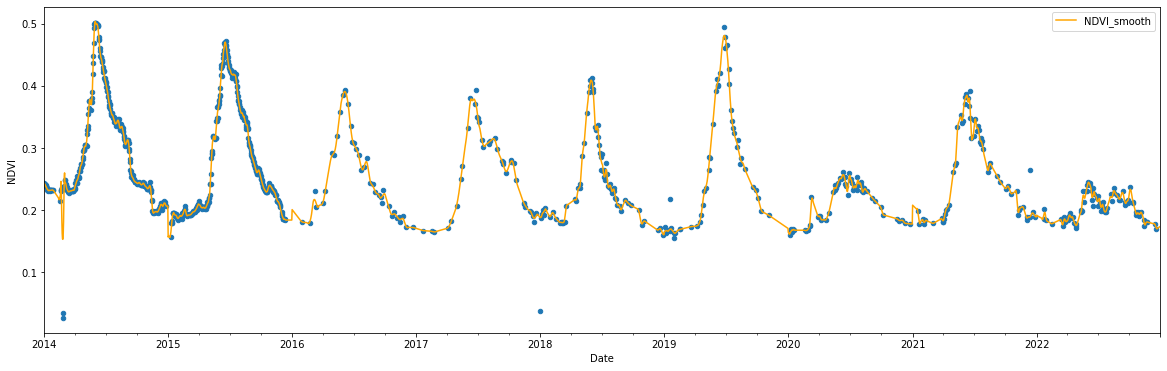

In [14]:
# plot original smooth from adaptive smoothing
fig, ax1 = plt.subplots(figsize=(20, 6))
plot = '15E_P4'
df_out_ndvi[df_out_ndvi['Id'] == plot].plot.scatter(x='Date', y='NDVI', ax=ax1)
df_out_ndvi[df_out_ndvi['Id'] == plot].plot(x='Date', y='NDVI_smooth', c='orange', ax=ax1)

In [ ]:
df_out_ndvi.to_csv(outPATH, index=False)

In [196]:
def full_smooth_ndvi(ts, dates):
    from scipy.signal import savgol_filter
    ndvi_min = ts[(dates.dt.month < 3) | (dates.dt.month > 10)].quantile(0.05)
    ts_ds = pd.Series(
        despike_ts(ts.values, dat_thresh=0.025, days_thresh=61)).interpolate(limit=None)
    ts_smooth = pd.Series(savgol_filter(ts_ds, 91, 3), index=ts.index)
    return ts_smooth

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)

# explore creating SOS
def calc_sos(ndvi_ts):
    ndvi_thresh1 = np.nanpercentile(ndvi_ts[91:201], 40.0)
    date_thresh1 = next(x for x in np.where(ndvi_ts > ndvi_thresh1)[0] if x > 30)
    dndvi_ts = np.ones_like(ndvi_ts) * np.nan
    dndvi_ts[25:] = running_mean(np.diff(ndvi_ts), 25)
    dndvi_thresh2 = np.nanpercentile(dndvi_ts[:date_thresh1], 35.0)
    sos = np.where(dndvi_ts[:date_thresh1] < dndvi_thresh2)[0][-1]
    return sos

def weighted_ndvi(ndvi_smooth1, ndvi_smooth2, sos):
    weights1 = np.ones_like(ndvi_smooth1)
    peak = np.argmax(ndvi_smooth1[120:300]) + 120
    weights1[:sos] = 0
    weights1[sos:peak] = np.linspace(0, 1, peak-sos)**4
    weights1[peak:] = np.linspace(1, 0, len(ndvi_smooth1) - peak)**4
    weights2 = 1.0 - weights1
    ndvi_wtd = np.average(np.array([ndvi_smooth1, ndvi_smooth2]), axis=0, weights=np.array([weights1, weights2]))
    return pd.Series(ndvi_wtd, index=ndvi_smooth1.index)
    

In [185]:
# run secondary smoothing on full time series
ndvi_ts_smooth = df_out_ndvi.groupby('Id').apply(lambda x: full_smooth_ndvi(x['NDVI'], x['Date']))
df_out_ndvi['NDVI_smooth2'] = ndvi_ts_smooth.droplevel(list(np.arange(ndvi_ts_smooth.index.nlevels-1)))

/project/cper_neon_aop/conda_envs/hls_nrt_env/lib/python3.9/site-packages/hlsstack/hls_funcs/smooth.py:186: RuntimeWarning: invalid value encountered in double_scalars
  shadow_val = dat_diff / (dat_ts_cln[idx_post] - dat_ts_cln[idx_pre])


In [186]:
# calculate start of season as DOY for each plot and year
df_sos = df_out_ndvi.groupby([df_out_ndvi['Date'].dt.year, 
                              'Id'])['NDVI_smooth2'].apply(
    lambda x: calc_sos(x)).reset_index().rename(columns={'NDVI_smooth2': 'SOS_doy',
                                                         'Date': 'Year'})
# get as date
df_sos['SOS_date'] = df_sos.apply(lambda x: datetime(x['Year'], 1, 1) + timedelta(days=x['SOS_doy']), axis=1)

# merge with NDVI for plotting
df_sos = pd.merge(df_sos, df_out_ndvi[['Date', 'Id', 'NDVI_smooth2']], 
         left_on=['SOS_date', 'Id'],
         right_on=['Date', 'Id'], how='left')

<AxesSubplot:xlabel='SOS_date', ylabel='NDVI_smooth2'>

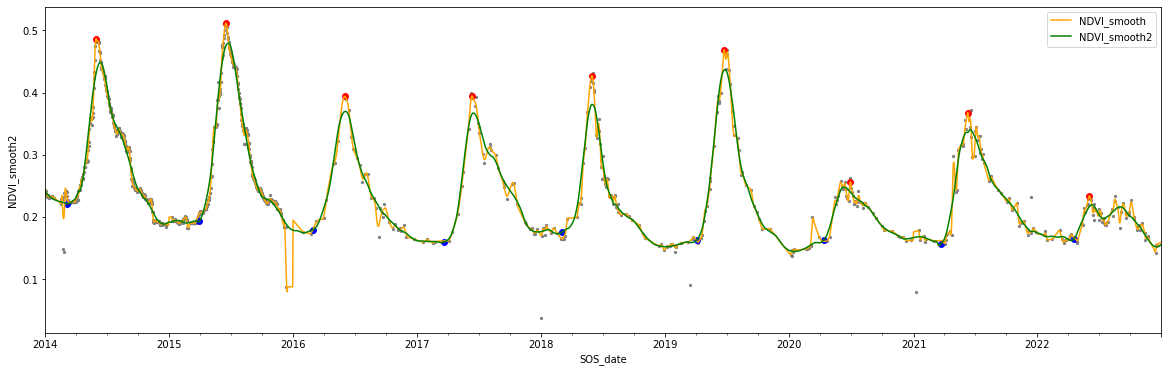

In [187]:
# plot updated smooth with start of season (blue) and peak of season (red)
fig, ax1 = plt.subplots(figsize=(20, 6))
plot = '15E_P2'
ndvi_peak_vals = df_out_ndvi[df_out_ndvi['Id'] == plot].groupby('Year').apply(lambda x: x['NDVI_smooth'].iloc[np.argmax(x['NDVI_smooth'])])
ndvi_peak_dates = df_out_ndvi[df_out_ndvi['Id'] == plot].groupby('Year').apply(lambda x: x['Date'].iloc[np.argmax(x['NDVI_smooth'])])
df_out_ndvi[df_out_ndvi['Id'] == plot].plot.scatter(x='Date', y='NDVI', ax=ax1, c='grey', s=5)
df_out_ndvi[df_out_ndvi['Id'] == plot].plot(x='Date', y='NDVI_smooth', c='orange', ax=ax1)
df_out_ndvi[df_out_ndvi['Id'] == plot].plot(x='Date', y='NDVI_smooth2', c='green', ax=ax1)
ax1.scatter(ndvi_peak_dates.values, ndvi_peak_vals.values, c='red', s=35)
df_sos[df_sos['Id'] == plot].plot.scatter(x='SOS_date', y='NDVI_smooth2',  ax=ax1, c='blue', s=35)

In [197]:
# get average from two smooths, weighted by distance to SOS and peak NDVI 
ndvi_smooth_avg = df_out_ndvi.groupby(['Year', 'Id']).apply(lambda x: weighted_ndvi(x['NDVI_smooth'], 
                                                                  x['NDVI_smooth2'],
                                                                  df_sos[(df_sos['Year'] == x.name[0]) & 
                                                                         (df_sos['Id'] == x.name[1])]['SOS_doy'].values[0]))
df_out_ndvi['NDVI_smooth_avg'] = ndvi_smooth_avg.droplevel(list(np.arange(ndvi_smooth_avg.index.nlevels-1)))

<AxesSubplot:xlabel='Date', ylabel='NDVI_smooth2'>

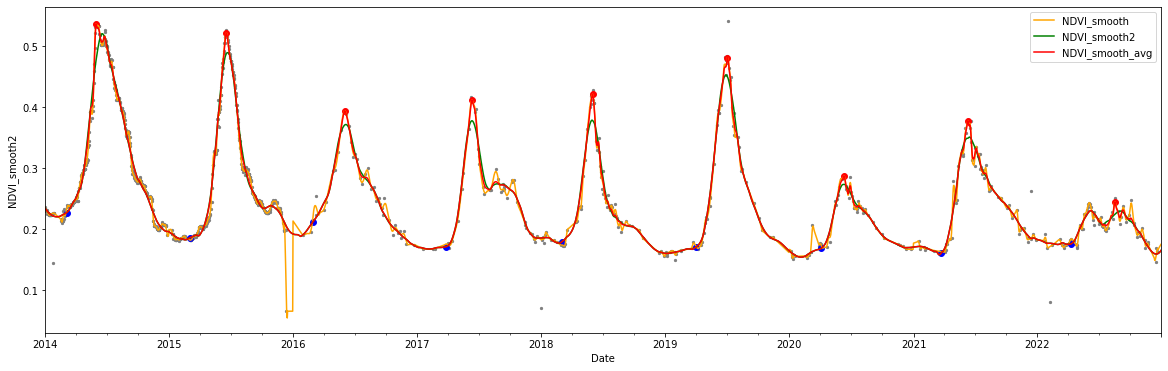

In [200]:
fig, ax1 = plt.subplots(figsize=(20, 6))
plot = '10S_P2'
ndvi_peak_vals = df_out_ndvi[df_out_ndvi['Id'] == plot].groupby('Year').apply(lambda x: x['NDVI_smooth'].iloc[np.argmax(x['NDVI_smooth'])])
ndvi_peak_dates = df_out_ndvi[df_out_ndvi['Id'] == plot].groupby('Year').apply(lambda x: x['Date'].iloc[np.argmax(x['NDVI_smooth'])])
df_out_ndvi[df_out_ndvi['Id'] == plot].plot.scatter(x='Date', y='NDVI', ax=ax1, c='grey', s=5)
df_out_ndvi[df_out_ndvi['Id'] == plot].plot(x='Date', y='NDVI_smooth', c='orange', ax=ax1)
df_out_ndvi[df_out_ndvi['Id'] == plot].plot(x='Date', y='NDVI_smooth2', c='green', ax=ax1)
ax1.scatter(ndvi_peak_dates.values, ndvi_peak_vals.values, c='red', s=35)
df_sos[df_sos['Id'] == plot].plot.scatter(x='SOS_date', y='NDVI_smooth2',  ax=ax1, c='blue', s=35)
df_out_ndvi[df_out_ndvi['Id'] == plot].plot(x='Date', y='NDVI_smooth_avg', ax=ax1, c='red')

In [206]:
df_out_ndvi.to_csv(re.sub('.csv', '_fnl.csv', outPATH_ndvi), index=False)

In [145]:
df_tmp = df_out_ndvi[(df_out_ndvi['Id'] == plot)  & 
            (pd.to_datetime(df_out_ndvi['Date']).dt.year == year)]

In [146]:
df_tmp['NDVI_smooth_avg'] = weighted_ndvi(df_tmp['NDVI_smooth'].values,
              df_tmp['NDVI_smooth2'].values, 
              df_sos[(df_sos['Id'] == plot) & (df_sos['Year'] == year)]['DOY'].values[0])

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [147]:
ndvi_smooth1 = df_tmp['NDVI_smooth'].values
ndvi_smooth2 = df_tmp['NDVI_smooth2'].values
sos = df_sos[(df_sos['Id'] == plot) & (df_sos['Year'] == year)]['DOY'].values[0]

In [154]:
weights1 = np.ones_like(ndvi_smooth1)
peak = np.argmax(ndvi_smooth1[120:300]) + 120
weights1[:sos] = 0
weights1[sos:peak] = np.linspace(0, 1, peak-sos)
weights1[peak:] = np.linspace(1, 0, len(ndvi_smooth1) - peak)
weights2 = 1.0 - weights1
ndvi_wtd = np.average(np.array([ndvi_smooth1, ndvi_smooth2]), axis=0, weights=np.array([weights1, weights2]))

In [155]:
peak

150

<AxesSubplot:xlabel='Date', ylabel='NDVI'>

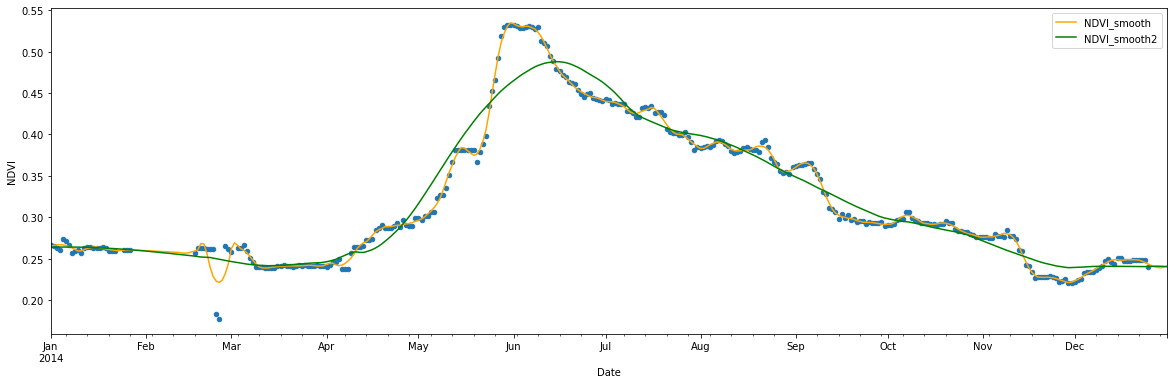

In [141]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(20, 6))
plot = '10S_P1'
year=2014
df_out_ndvi[(df_out_ndvi['Id'] == plot) & 
            (pd.to_datetime(df_out_ndvi['Date']).dt.year == year)].plot.scatter(x='Date', y='NDVI', ax=ax1)
df_out_ndvi[(df_out_ndvi['Id'] == plot)  & 
            (pd.to_datetime(df_out_ndvi['Date']).dt.year == year)].plot(x='Date', y='NDVI_smooth', c='orange', ax=ax1)
df_out_ndvi[(df_out_ndvi['Id'] == plot)  & 
            (pd.to_datetime(df_out_ndvi['Date']).dt.year == year)].plot(x='Date', y='NDVI_smooth2', c='green', ax=ax1)
#df_tmp.plot(x='Date', y='NDVI_smooth_avg', c='red', ax=ax1)

<AxesSubplot:xlabel='SOS_date', ylabel='NDVI_smooth2'>

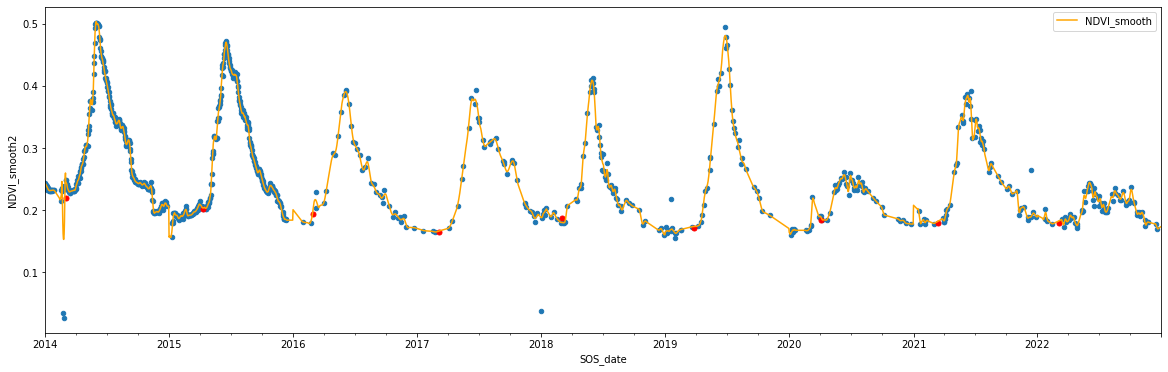

In [37]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(20, 6))
plot = '15E_P4'
df_out_ndvi[df_out_ndvi['Id'] == plot].plot.scatter(x='Date', y='NDVI', ax=ax1)
df_out_ndvi[df_out_ndvi['Id'] == plot].plot(x='Date', y='NDVI_smooth', c='orange', ax=ax1)
df_sos[df_sos['Id'] == plot].plot.scatter(x='SOS_date', y='NDVI_smooth2',  ax=ax1, c='red', s=25)

In [10]:
df_out_ndvi = pd.read_csv(outPATH_ndvi, parse_dates=[0])

In [90]:
from scipy.signal import savgol_filter
plot = '15E_P4'
year = 2016

In [175]:
def adapt_smooth_ndvi(ts, dates, despike=True):
    ct_valid = sum(~np.isnan(ts[(dates.dt.month >= 3) & (dates.dt.month <= 10)]))
    if despike:
        ts_ds = despike_ts(ts.values, dat_thresh=0.05, days_thresh=45)
    else:
        ts_ds = ts.values
    if 180 / ct_valid > 10:
        ts_smooth = double_savgol(ts_ds, double=True, window2=43, limit=91)
    elif 180 / ct_valid > 7:
         ts_smooth = double_savgol(ts_ds, double=True, window2=21, limit=91)
    elif 180 / ct_valid > 5:
         ts_smooth = double_savgol(ts_ds, double=False, window2=21, limit=91)
    else:
        ts_smooth = double_savgol(ts_ds, double=False, window2=11, limit=91)
    return pd.Series(ts_smooth, ts.index.get_level_values(-1))

In [188]:
df_out_ndvi['NDVI_smooth2'] = df_out_ndvi.groupby([df_out_ndvi['Date'].dt.year, 'Id']).apply(
    lambda x: adapt_smooth_ndvi(x['NDVI'], x['Date'])).droplevel(list(np.arange(test.index.nlevels-1)))

/project/cper_neon_aop/conda_envs/hls_nrt_env/lib/python3.9/site-packages/hlsstack/hls_funcs/smooth.py:186: RuntimeWarning: invalid value encountered in double_scalars
  shadow_val = dat_diff / (dat_ts_cln[idx_post] - dat_ts_cln[idx_pre])


<AxesSubplot:xlabel='Date', ylabel='NDVI'>

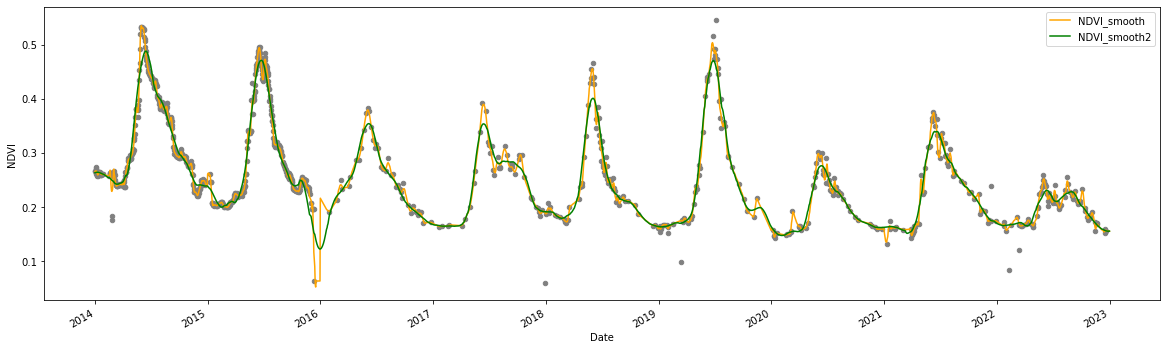

In [85]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(20, 6))
plot = '10S_P1'
df_out_ndvi[df_out_ndvi['Id'] == plot].plot.scatter(x='Date', y='NDVI', ax=ax1, c='grey')
df_out_ndvi[df_out_ndvi['Id'] == plot].plot(x='Date', y='NDVI_smooth', c='orange', ax=ax1)
df_out_ndvi[df_out_ndvi['Id'] == plot].plot(x='Date', y='NDVI_smooth2', c='green', ax=ax1)

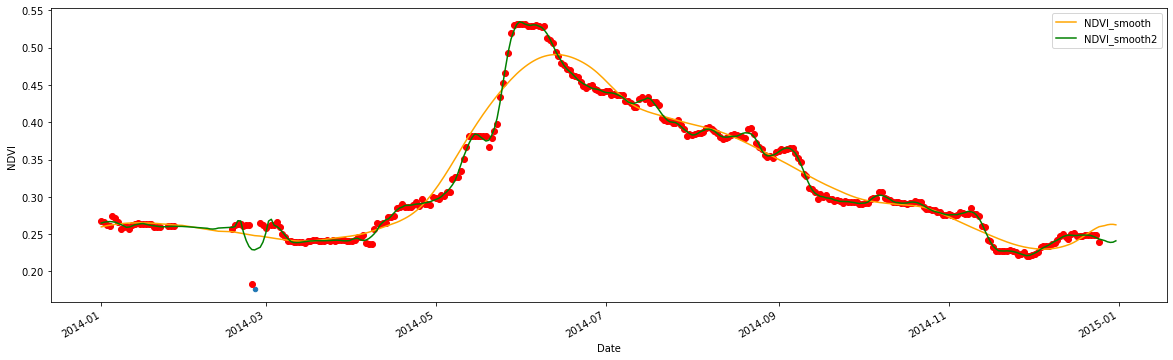

In [199]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(20, 6))
plot = '10S_P1'
year=2014
df_out_ndvi[(df_out_ndvi['Id'] == plot) & 
            (pd.to_datetime(df_out_ndvi['Date']).dt.year == year)].plot.scatter(x='Date', y='NDVI', ax=ax1)
df_out_ndvi[(df_out_ndvi['Id'] == plot)  & 
            (pd.to_datetime(df_out_ndvi['Date']).dt.year == year)].plot(x='Date', y='NDVI_smooth', c='orange', ax=ax1)
df_out_ndvi[(df_out_ndvi['Id'] == plot)  & 
            (pd.to_datetime(df_out_ndvi['Date']).dt.year == year)].plot(x='Date', y='NDVI_smooth2', c='green', ax=ax1)
ts = df_out_ndvi[(df_out_ndvi['Id'] == plot) & 
            (pd.to_datetime(df_out_ndvi['Date']).dt.year == year)]['NDVI'].values
ts[ts == min(ts)] = np.nan
ts_ds = ts
#ts_ds = despike_ts(ts, dat_thresh=0.05, days_thresh=45, iters=2)
ax1.scatter(x=df_out_ndvi[(df_out_ndvi['Id'] == plot) & 
            (pd.to_datetime(df_out_ndvi['Date']).dt.year == year)]['Date'],
           y=ts_ds, c='red')

In [123]:
((270-90) / sum(~np.isnan(vals[90:270])))

7.5

In [126]:
dates = df_out_ndvi[(df_out_ndvi['Id'] == plot) & 
            (pd.to_datetime(df_out_ndvi['Date']).dt.year == year)]['Date']
vals = df_out_ndvi[(df_out_ndvi['Id'] == plot) & 
            (pd.to_datetime(df_out_ndvi['Date']).dt.year == year)]['NDVI'].values
vals_interp = df_out_ndvi[(df_out_ndvi['Id'] == plot) & 
            (pd.to_datetime(df_out_ndvi['Date']).dt.year == year)]['NDVI'].interpolate().interpolate(method='linear', limit=None, limit_direction='both',
                                          limit_area='outside').values
test = adapt_smooth_ndvi(vals)
#test = double_savgol(despike_ts(vals, dat_thresh=0.05, days_thresh=45), double=False, window2=11, limit=91)
#test2 = confsmooth(vals_interp, noise_level=0.04, overlap_fraction=0.9, deg=3)

7.5


In [28]:
vals_interp

array([0.15739983, 0.15739983, 0.15739983, 0.15739983, 0.15739983,
       0.15739983, 0.15739983, 0.15739983, 0.17895439, 0.17877836,
       0.17874562, 0.18327235, 0.19542282, 0.19584102, 0.19583482,
       0.19604467, 0.19536159, 0.19196508, 0.19054524, 0.1929308 ,
       0.19143532, 0.19314947, 0.19315428, 0.19114468, 0.19030271,
       0.18778603, 0.18764725, 0.18750004, 0.18465784, 0.18678029,
       0.18864386, 0.18866095, 0.18939015, 0.19048632, 0.19125013,
       0.19132666, 0.19081032, 0.19099156, 0.1901133 , 0.19123591,
       0.18611537, 0.19513901, 0.19518762, 0.19519425, 0.19536579,
       0.19541699, 0.19943747, 0.19812907, 0.20695548, 0.20186927,
       0.20194791, 0.1935774 , 0.19385608, 0.19161682, 0.19149748,
       0.1914219 , 0.19233913, 0.19309035, 0.19185306, 0.19182985,
       0.19244136, 0.19240747, 0.19355707, 0.19402033, 0.19443468,
       0.1948227 , 0.19534796, 0.19668733, 0.19736649, 0.19847761,
       0.1976196 , 0.19719866, 0.19727418, 0.19715039, 0.19870

In [6]:
import numpy as np
from scipy.special import erfc


def is_array(obj):
    if isinstance(obj, (dict, str)): return False
    return hasattr(obj, "__len__")


def confsmooth(y, noise_level, confidence=0.999, overlap_fraction=0.5, deg=2):
    """
    Smooth experimental spectrum, keeping peak intensity

    :param y: function values
    :param noise_level: scalar or vector of the same size as y, containing standard deviations of the noise
    :param confidence: errors with probability < 1-confidence are treated as signal and are not smoothed
    :param overlap_fraction: how many percent of points of interval to use for overlap
    :param deg: degree of polynomial
    :returns: smoothed y
    """
    n = len(y)
    if not is_array(noise_level): noise_level = np.ones(n)*noise_level

    def approx_error(y):
        x_i = np.arange(len(y))  # we do not take x into account!
        p = np.polyfit(x_i, y, deg)
        pred = np.polyval(p, x_i)
        return pred, y-pred

    def is_noise_possible_ext(error, sigma):
        ind = sigma>0
        error = error[ind]
        if len(error) == 0:
            if np.any(error) > 1e-6: return False
            else: return True
        if np.all(error == 0): return True
        sigma = sigma[ind]
        noise_prob = erfc(np.abs(error)/sigma/np.sqrt(2))
        if np.any(noise_prob < 1-confidence): return False
        for j in range(2,len(error)//2):
            error1 = np.convolve(error,np.ones(j)/j, 'valid')
            sigma1 = sigma[j//2:j//2+len(error1)]/np.sqrt(j)
            noise_prob = erfc(np.abs(error1)/sigma1/np.sqrt(2))
            if np.any(noise_prob < 1-confidence): return False
        return True

    def is_noise_possible(i0, size):
        error = approx_error(y[i0:i0 + size])[1]
        return is_noise_possible_ext(error, noise_level[i0:i0+size])

    def detect_segment_size(i0, old_size):
        sz = old_size
        is_ns_possible = is_noise_possible(i0, sz)
        if is_ns_possible:
            while is_ns_possible:
                sz = sz + 1
                if i0+sz > len(y): return sz-1
                is_ns_possible = is_noise_possible(i0, sz)
            return sz-1
        else:
            while not is_ns_possible:
                sz = sz - 1
                assert sz >= 2
                is_ns_possible = is_noise_possible(i0, sz)
            return sz

    i0 = 0
    old_size = deg+1
    result = np.zeros(n)
    osz = 0
    while True:
        new_size = detect_segment_size(i0, old_size)
        # print(f'i0 = {i0} new_size = {new_size} old_size = {old_size} osz = {osz}')
        pred, error = approx_error(y[i0:i0 + new_size])
        if i0 == 0:
            result[:new_size] = pred
            osz = int(np.round(new_size*overlap_fraction))
            if osz == 0: osz = 1
        else:
            # overlap with old
            corrected_osz = min(osz, new_size)
            if corrected_osz >= 3:
                alpha = np.linspace(0,1,corrected_osz)
            else:
                alpha = np.ones(corrected_osz)/2
            result[i0:i0+corrected_osz] = (1-alpha)*result[i0:i0+corrected_osz] + alpha*pred[:corrected_osz]
            # middle
            result[i0+corrected_osz:i0+new_size] = pred[corrected_osz:]
            #overlap with new
            osz = int(np.round(new_size*overlap_fraction))
            if osz == 0: osz = 1
        if i0+new_size >= len(y): break
        i0 = i0 + new_size - osz
        old_size = new_size

    return result
